# Display sequencing emo-bon efforts across European sites
- At first showing the validated and relessed data from [emo-bon-data-validataion](https://github.com/emo-bon/emo-bon-data-validation/tree/main/validated-data)
- Second, ask Cymon what metadata can be shown about data which are not ready/released yet.
- I use `leafmap` for GIS integration

In [1]:
# system dependent setup
import sys
import os
import logging
from IPython import get_ipython

logger = logging.getLogger(name="Sequencing Progress")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install marine-omics')

    os.system('pip install leafmap')
    logger.info(f"leafmap installed")

from momics.utils import (
    init_setup, reconfig_logger
)

# Set up logging
reconfig_logger()
init_setup()


INFO | root | Logging.basicConfig completed successfully


## Import

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import leafmap
from ipywidgets import Layout

from mgo.udal import UDAL

## User settings

In [3]:
DEBUG = True  # enable stdout logging

## Loading
- no udal for sequencing master yet (there is no final public place to point to properly, since it is half internal process information)

In [4]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
    df_tracker = pd.read_csv(os.path.join(root_folder,"wf0_landing_page/emobon_sequencing_master.csv") ,index_col=False)
else:
    root_folder = os.path.abspath(os.path.join('../'))
    df_tracker = pd.read_csv("emobon_sequencing_master.csv" ,index_col=False)

assets_folder = os.path.join(root_folder, 'assets')

### Data from the validated-data repo ran through pydantic by Cymon

In [5]:
udal = UDAL()

In [6]:
# sample logsheets udal
df_metadata = udal.execute('urn:embrc.eu:emobon:logsheets').data()

# udal observatories
df_obs = udal.execute('urn:embrc.eu:emobon:observatories').data().set_index('obs_id')

# change string that ';' is followed by a space
df_obs['organization'] = df_obs['organization'].str.replace('; ', ';')
df_obs['organization'] = df_obs['organization'].str.replace(';', '; ')

# df_obs.head()

In [7]:
# manual hash table because names are pain in the backside and long
org_hash = {
    'EMT21': 'Toralla Marine Science Station',
    'UMF': 'Umea Marine Sciences Centre',
    'ROSKOGO': 'Station Biologique de Roscoff',
    'LMO': 'Linnaeus University',
    'BPNS': 'Flanders Marine Institute (VLIZ)',
    'ESC68N': 'The Arctic University of Norway (UiT)',
    'OOB': 'Observatoire Océanologique de Banyuls',
    'RFormosa': 'Centre of Marine Sciences (CCMAR)',
    'Bergen': 'University of Bergen (UiB)',
    'OSD74': 'CIIMAR Porto',
    'VB': 'Institut de la Mer de Villefranche',
    'MBAL4': 'Marine Biological Association, Plymouth',
    'HCMR-1': 'Hellenic Centre for Marine Research',
    'NRMCB': 'Stazione Zoologica Anton Dohrn',
    'PiEGetxo': 'Plentzia Marine Station',
    'IUIEilat': 'Interuniversity Institute for Marine Sciences in Eilat',
    'AAOT': 'Institute of Marine Science, (ISMAR)'
}


# statistics part
def get_stats(df: pd.DataFrame, hash) -> pd.DataFrame:
    # pivot table on run_status
    df_pivot = df.pivot_table(index="obs_id", columns=["run_status", 'batch'], values="organization",
                              aggfunc="count")

    df_pivot['sequenced'] = df_pivot.groupby(level=0, axis=1).sum()["COMPLETED"].astype(int)
    df_pivot["total"] = df.groupby("obs_id").count()["ref_code"].astype(int)
    df_pivot["percentage"] = round(df_pivot['sequenced'] / df_pivot["total"] * 100, ndigits=2)

    #replace Nan in run_status with 'queued'
    df['run_status'] = df['run_status'].fillna('queued')

    # remove lines which are not in org_hash
    df = df[df['obs_id'].isin(hash.keys())]
    df_pivot2 = df.pivot_table(index="obs_id",
                               columns=["run_status", "sample_type"],
                               values="organization",
                               aggfunc="count")
    return df_pivot, df_pivot2




### This is the table to display in the workflow

In [8]:
# Failed attempt to clean and shorted the org names automatically
organizations = df_obs[['organization']]

# remore duplicates
organizations = organizations.drop_duplicates()
organizations = organizations[organizations['organization'] != 'Estación de Ciencias Mariñas de Toralla - Centre of Marine Research, University of Vigo']

In [9]:
# add organization column from the df_obs to the df_tracker based on the obs_id
df_tracker = pd.merge(df_tracker, organizations, on="obs_id", how="left")

In [10]:
# TODO: refactor to func and put to the momics module.

df_stats, df_aggregated = get_stats(df_tracker, org_hash)
# Reset index to merge properly
df_stats = df_stats.reset_index()

# Flatten the multi-level columns
df_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_stats.columns]

df_stats = pd.merge(df_stats, organizations, left_on="obs_id_", right_index=True, how="left")
# remove trailing _ from the column names
df_stats.columns = df_stats.columns.str.rstrip('_')

# set index
df_stats.set_index('obs_id', inplace=True)


print(df_stats['total'].sum())
df_stats.head()

565


,COMPLETED_001,COMPLETED_002,sequenced,total,percentage,organization
obs_id,,,,,,
AAOT,7.0,8.0,15,34,44.12,National Research Council Institute of Marine ...
BPNS,11.0,12.0,23,81,28.40,Flanders Marine Institute (VLIZ); Ghent Univer...
EMT21,4.0,8.0,12,36,33.33,Toralla Marine Science Station - Centre of Mar...
ESC68N,4.0,2.0,6,30,20.00,The Arctic University of Norway (UiT)
HCMR-1,3.0,NaN,3,38,7.89,Institute of Marine Biology Biotechnology and ...


In [11]:
df_aggregated.head()

run_status  COMPLETED           queued                                      
sample_type   filters sediment filters filters_blank sediment sediment_blank
obs_id                                                                      
AAOT             15.0      NaN    17.0           2.0      NaN            NaN
BPNS             16.0      7.0    16.0           2.0     37.0            3.0
Bergen            NaN      NaN    12.0           2.0      NaN            NaN
EMT21            12.0      NaN    12.0           2.0     10.0            NaN
ESC68N            6.0      NaN    22.0           2.0      NaN            NaN

### Notes on what I need
- I want to show NUMBER + PERCENTAGE of processed samplings per station
- granular per batch

## GIS methods

In [ ]:
def create_map(df: pd.DataFrame) -> leafmap.Map:
    # Create a map centered at the given coordinates
    m = leafmap.Map(center=(50, 10), zoom=4,
                    layout=Layout(height='800px')
                    )
    m.add_points_from_xy(
        df, x="longitude", y="latitude",
        popup=['organization', "contact_name", "contact_email", "ENA_accession_number_umbrella", 'tot_depth_water_col'],
        layer_name="EMO-BON Observatories",
        max_cluster_radius=10,
        )
    return m

def progress_per_station_plot(df: pd.DataFrame, hash_table: dict = None) -> None:
    list_indicators = []

    # Prepare data for barplot
    station_names = [org_hash.get(station, station) for station in df.index]
    sequenced = df["sequenced"]
    total = df["total"]
    percentages = df["percentage"]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(station_names, sequenced, color='skyblue', label='Sequenced')
    ax.bar(station_names, total, color='lightgray', alpha=0.3, label='Total', zorder=0)

    # Annotate bars with percentage
    for i, (bar, pct) in enumerate(zip(bars, percentages)):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{pct:.1f}%", 
                ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Number of Samples')
    ax.set_title('Sequencing Progress per Station')
    ax.set_xticklabels(station_names, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [22]:
obs_map = create_map(df_obs)
obs_map  # This will display the interactive map in the notebook

Map(center=[50, 10], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

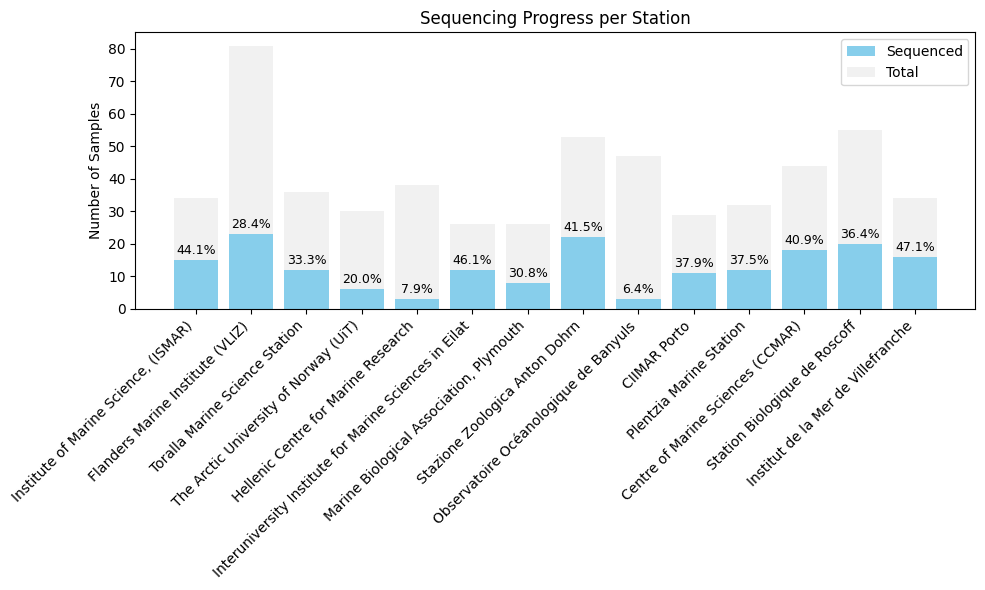

In [25]:
progress_per_station_plot(df_stats, org_hash)